# Used Car Price Prediction

# Import Libraries

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler

# Loading Data

In [5]:
filePath = 'used_cars.csv'
df = pd.read_csv(filePath)

# EDA -> Exploratory Data Analysis

In [7]:
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   object
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.0+ KB


In [9]:
df.describe()

,model_year
count,4009.000000
mean,2015.515590
std,6.104816
min,1974.000000
25%,2012.000000
50%,2017.000000
75%,2020.000000
max,2024.000000


In [10]:
df.isnull().sum()

brand             0
model             0
model_year        0
milage            0
fuel_type       170
engine            0
transmission      0
ext_col           0
int_col           0
accident        113
clean_title     596
price             0
dtype: int64

In [89]:
df.duplicated().sum()

0

# Preprocessing

## Replace prefix

In [93]:
df['milage'] = df['milage'].str.replace(' mi.', '').str.replace(',', '').astype(int)

In [95]:
df['price'] = df['price'].str.replace('$', '').str.replace(',', '').astype(int)

## Feature Extraction

In [98]:
# Create hp column
df['hp'] = df['engine'].str.extract(r'(\d+\.\d+)HP').astype(float, errors='ignore')

# Create engine displacement
df['engine displacement'] = df['engine'].str.extract(r'(\d+\.\d+)\s*L')
df['engine displacement'] = df['engine displacement'].fillna(df['engine'].str.extract(r'(\d+\.\d+)\s*LITER')[0])
df['engine displacement'] = df['engine displacement'].astype(float, errors='ignore')

# Is it V type or not
df['is_v_engine'] = df['engine'].str.contains(r'V\d+', case=False, na=False)

## Cleaning the `fuel_type` feature

In [101]:
df['fuel_type'] = df['fuel_type'].str.strip().str.upper().replace({'PLUG-IN HYBRID': 'HYBRID', 'NOT SUPPORTED':'OTHER', '–':'OTHER'})

df['fuel_type'].value_counts()

fuel_type
GASOLINE         3275
HYBRID            225
E85 FLEX FUEL     139
OTHER             127
DIESEL            116
Name: count, dtype: int64

## Cleaning the `transmission` feature

In [104]:
def classify_transmission(transmission):
    T = str(transmission).upper()

    if 'M/T' in T or 'MT' in T or 'MANUAL' in T:
        return 'M/T'
    elif 'A/T' in T or 'AT' in T or 'AUTOMATIC' in T:
        return 'A/T'
    elif 'CVT' in T or 'VARIABLE' in T or 'SINGLE-SPEED' in T:
        return 'CVT'
    else:
        return 'OTHER'

df['transmission'] = df['transmission'].apply(classify_transmission)

df['transmission'].unique()

array(['A/T', 'OTHER', 'M/T', 'CVT'], dtype=object)

## Handle Missing Values

In [107]:
df['hp'] = df.groupby('brand')['hp'].transform(lambda x: x.fillna(x.mean()))

df.dropna(subset=['hp'], inplace=True)

In [109]:
most_common_fuel = df.groupby('brand')['fuel_type'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)

df['fuel_type'] = df.apply(
    lambda row: most_common_fuel[row['brand']] if pd.isna(row['fuel_type']) else row['fuel_type'],
    axis=1
)

df['fuel_type'] = df['fuel_type'].fillna('OTHER')

In [111]:
most_common_displacement = df.groupby('brand')['engine displacement'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)

df['engine displacement'] = df.apply(
    lambda row: most_common_displacement[row['brand']] if pd.isna(row['engine displacement']) else row['engine displacement'],
    axis=1
)

df['engine displacement'] = df['engine displacement'].fillna(df['engine displacement'].median())

## Remove Outliers

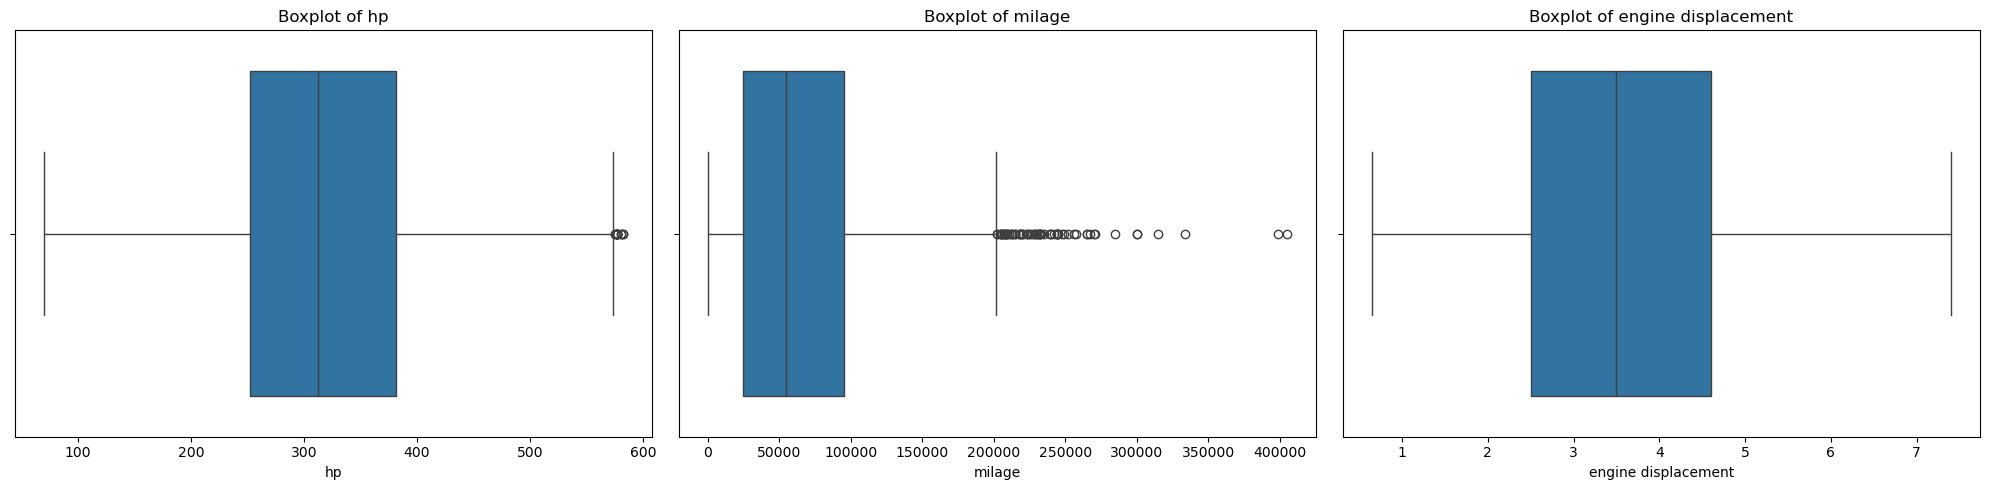

In [114]:
columns = ['hp', 'milage', 'engine displacement']

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes = axes.flatten()

for i, col in enumerate(columns):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel(f'{col}')

plt.tight_layout()
plt.show()


In [116]:
columns = ['engine displacement', 'hp', 'price', 'milage']
for col in columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [118]:
df.shape

(3598, 15)

## Encoding Categorical Features

In [121]:
df['Accident_Impact'] = df['accident'].apply(lambda x: 1 if x == 'At least 1 accident or damage reported' else 0)

In [123]:
df['clean_title'] = df['clean_title'].apply(lambda x: 1 if x == 'Yes' else 0)

In [125]:
vis_df = df.copy()
vis_df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,hp,engine displacement,is_v_engine,Accident_Impact
0,Ford,Utility Police Interceptor Base,2013,51000,E85 FLEX FUEL,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,A/T,Black,Black,At least 1 accident or damage reported,1,10300,300.000000,3.7,True,1
1,Hyundai,Palisade SEL,2021,34742,GASOLINE,3.8L V6 24V GDI DOHC,A/T,Moonlight Cloud,Gray,At least 1 accident or damage reported,1,38005,246.700000,3.8,True,1
2,Lexus,RX 350 RX 350,2022,22372,GASOLINE,3.5 Liter DOHC,A/T,Blue,Black,None reported,0,54598,303.659259,3.5,False,0
3,INFINITI,Q50 Hybrid Sport,2015,88900,HYBRID,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,A/T,Black,Black,None reported,1,15500,354.000000,3.5,True,0
4,Audi,Q3 45 S line Premium Plus,2021,9835,GASOLINE,2.0L I4 16V GDI DOHC Turbo,A/T,Glacier White Metallic,Black,None reported,0,34999,309.748387,2.0,False,0


In [127]:
categorical_columns = ['fuel_type', 'transmission', 'is_v_engine']

for cat_col in categorical_columns:
    encoder = LabelEncoder()
    df[cat_col] = encoder.fit_transform(df[cat_col])

## Feature Engineering

In [130]:
df['Vehicle_Age'] = 2025 - df['model_year']

In [132]:
df['Mileage_per_Year'] = df.apply(
    lambda row: row['milage'] / row['Vehicle_Age'] if row['Vehicle_Age'] > 0 else row['milage'],
    axis=1
)

In [134]:
# Binning
df['Vehicle_Age_Bin'] = pd.qcut(df['Vehicle_Age'], q=4, labels=['New', 'Mid', 'Old', 'Very Old'])
df['Mileage_Bin'] = pd.qcut(df['milage'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# One-hot encode
df = pd.get_dummies(df, columns=['Vehicle_Age_Bin', 'Mileage_Bin'], prefix=['Age', 'Milage'], drop_first=True, dtype=int)

## Drop Unused Features

In [137]:
df.drop(['model', 'model_year', 'engine', 'milage', 'int_col', 'ext_col', 'accident'], axis = 1, inplace = True)

In [139]:
df.isnull().sum()

brand                  0
fuel_type              0
transmission           0
clean_title            0
price                  0
hp                     0
engine displacement    0
is_v_engine            0
Accident_Impact        0
Vehicle_Age            0
Mileage_per_Year       0
Age_Mid                0
Age_Old                0
Age_Very Old           0
Milage_Medium          0
Milage_High            0
Milage_Very High       0
dtype: int64

In [141]:
df.head()

,brand,fuel_type,transmission,clean_title,price,hp,engine displacement,is_v_engine,Accident_Impact,Vehicle_Age,Mileage_per_Year,Age_Mid,Age_Old,Age_Very Old,Milage_Medium,Milage_High,Milage_Very High
0,Ford,1,0,1,10300,300.000000,3.7,1,1,12,4250.000000,0,1,0,1,0,0
1,Hyundai,2,0,1,38005,246.700000,3.8,1,1,4,8685.500000,0,0,0,1,0,0
2,Lexus,2,0,0,54598,303.659259,3.5,0,0,3,7457.333333,0,0,0,0,0,0
3,INFINITI,3,0,1,15500,354.000000,3.5,1,0,10,8890.000000,0,1,0,0,1,0
4,Audi,2,0,0,34999,309.748387,2.0,0,0,4,2458.750000,0,0,0,0,0,0


# Data Visualization

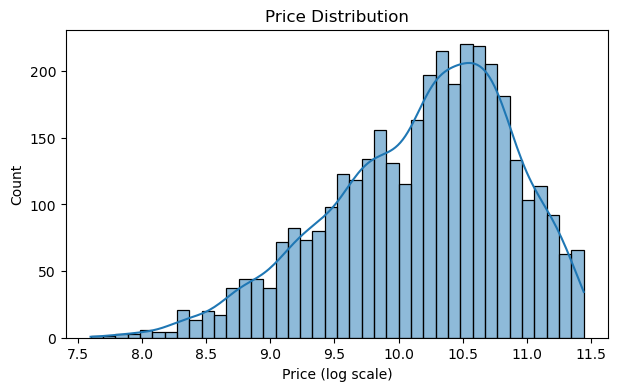

In [144]:
plt.figure(figsize=(7,4))
sns.histplot(np.log1p(df['price']), bins=40, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price (log scale)')
plt.ylabel('Count')
plt.show()

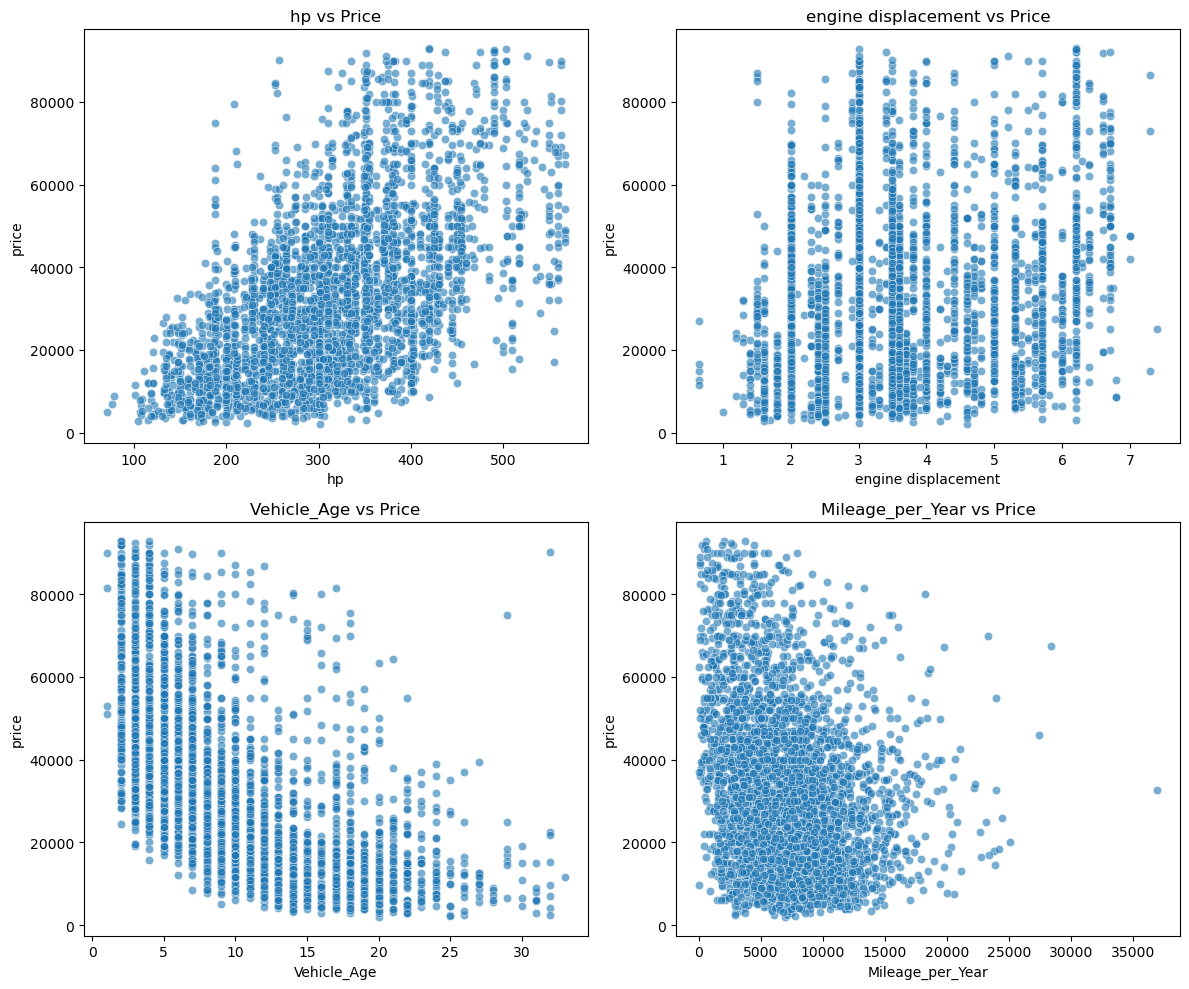

In [145]:
num_cols = ['hp','engine displacement','Vehicle_Age','Mileage_per_Year']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.scatterplot(x=df[col], y=df['price'], alpha=0.6, ax=axes[i])
    axes[i].set_title(f'{col} vs Price')

plt.tight_layout()
plt.show()

<Axes: >

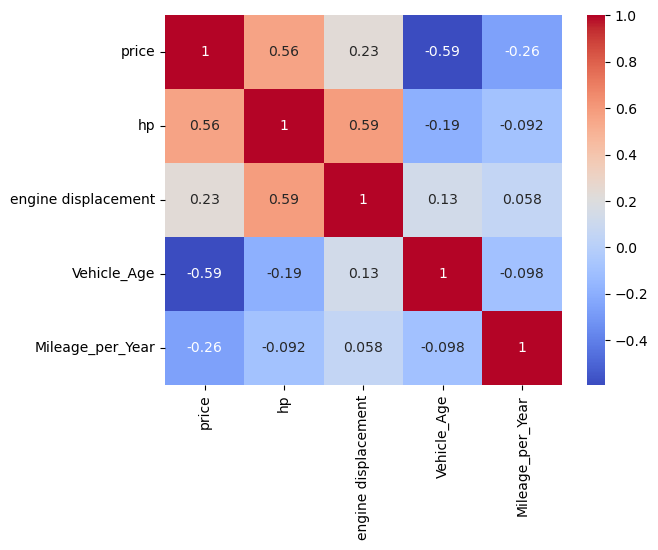

In [147]:
num_features = ['price','hp','engine displacement','Vehicle_Age','Mileage_per_Year']
sns.heatmap(df[num_features].corr(), annot=True, cmap='coolwarm')

C:\Users\USER\AppData\Local\Temp\ipykernel_10900\1660663972.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


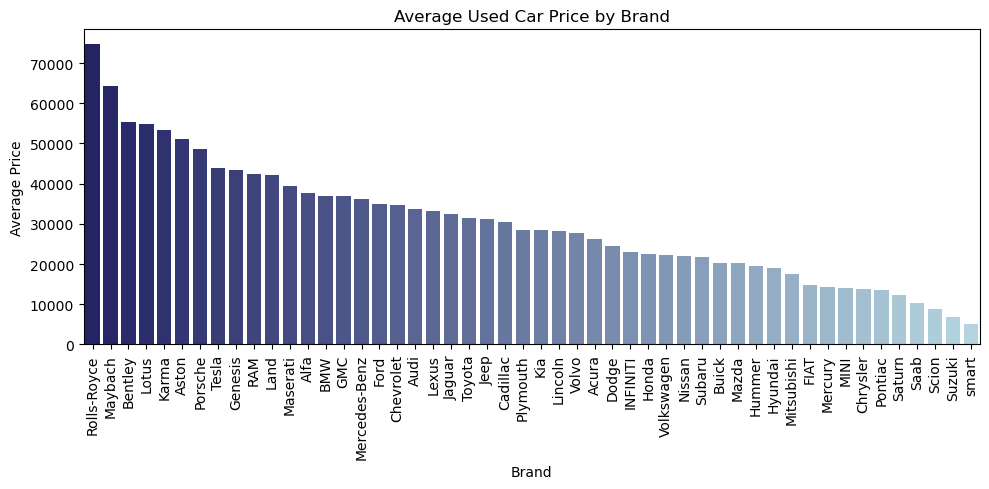

In [148]:
brand_avg_price = (
    vis_df.groupby('brand')['price']
      .mean()
      .sort_values(ascending=False)
)

plt.figure(figsize=(10,5))
sns.barplot(
    x=brand_avg_price.index,
    y=brand_avg_price.values,
    palette=sns.color_palette("blend:midnightblue,lightblue", n_colors=len(brand_avg_price)
))
plt.xticks(rotation=90)
plt.title("Average Used Car Price by Brand")
plt.xlabel("Brand")
plt.ylabel("Average Price")
plt.tight_layout()
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_10900\3715148980.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


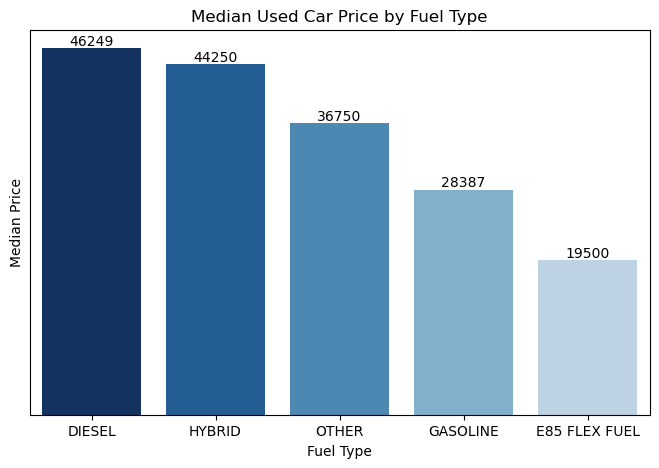

In [149]:
order = (
    vis_df.groupby('fuel_type')['price']
          .median()
          .sort_values(ascending=False)
          .index
)


medians = vis_df.groupby('fuel_type')['price'].median().loc[order]

# Color Grediant
cmap = plt.colormaps.get_cmap('Blues')
colors = [cmap(x) for x in np.linspace(1, 0.3, len(medians))]

plt.figure(figsize=(8,5))
ax = sns.barplot(
    x='fuel_type',
    y='price',
    data=vis_df,
    order=order,
    estimator=np.median,
    errorbar=None,
    palette=colors
)

plt.title("Median Used Car Price by Fuel Type")
plt.xlabel("Fuel Type")
ax.set_ylabel("Median Price")
ax.set_yticks([])


for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.0f}',
        (p.get_x() + p.get_width()/2, p.get_height()),
        ha='center', va='bottom', fontsize=10, color='black'
    )

plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_10900\1959996135.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


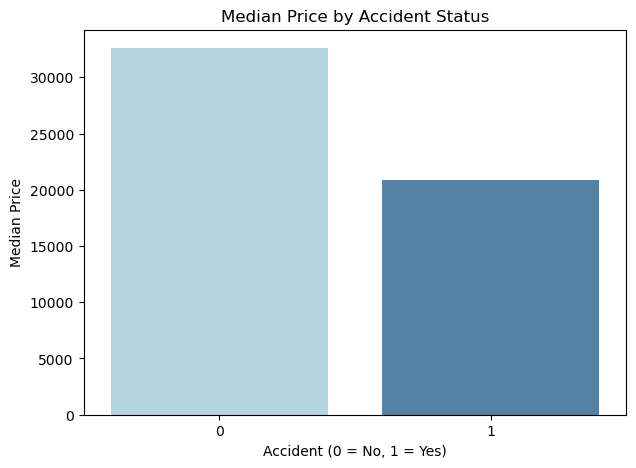

In [150]:
plt.figure(figsize=(7,5))

sns.barplot(
    x='Accident_Impact',
    y='price',
    data=vis_df,
    estimator=np.median,
    errorbar=None,
    palette= ['lightblue','steelblue']
)

plt.title("Median Price by Accident Status")
plt.xlabel("Accident (0 = No, 1 = Yes)")
plt.ylabel("Median Price")
plt.show()

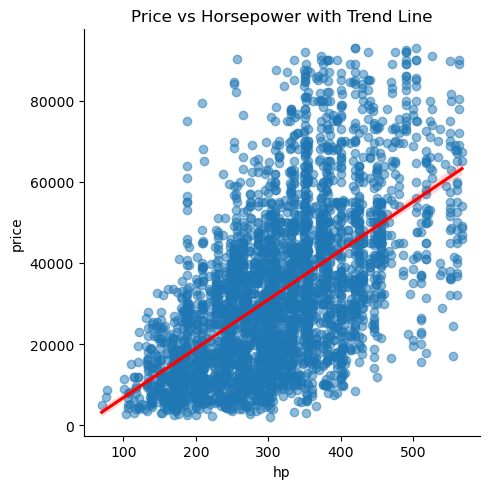

In [151]:
sns.lmplot(data=df, x='hp', y='price', line_kws={'color':'red'}, scatter_kws={'alpha':0.5})
plt.title('Price vs Horsepower with Trend Line')
plt.tight_layout()
plt.show()

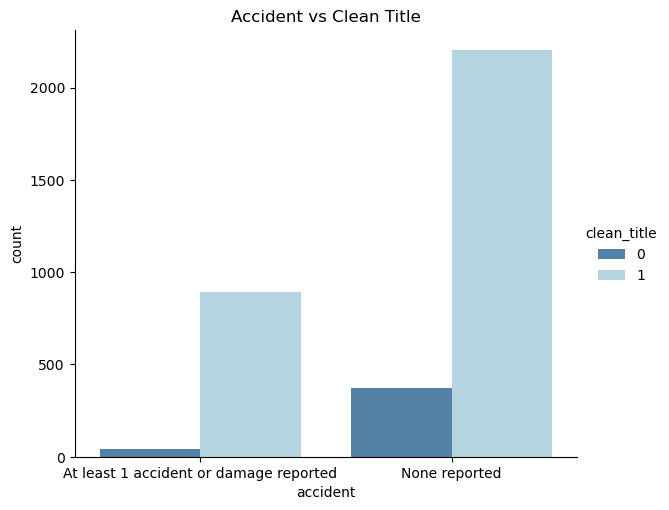

In [153]:
acc_ct = vis_df.groupby(['accident','clean_title']).size().reset_index(name='count')
sns.catplot(data=acc_ct, x='accident', y='count', hue='clean_title',
            kind='bar', height=5, aspect=1.2,
            palette = ["steelblue","lightblue"]
            )
plt.title('Accident vs Clean Title')
plt.show()

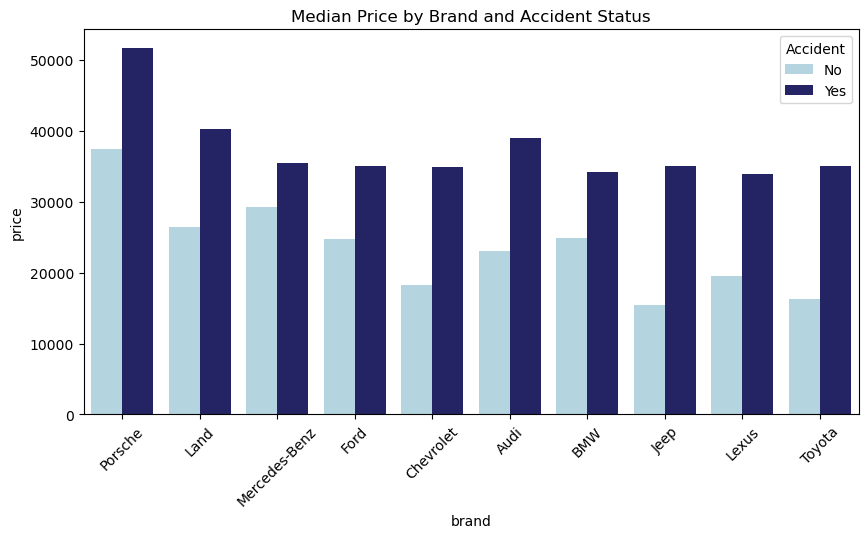

In [154]:
top_brands = vis_df['brand'].value_counts().nlargest(10).index

brand_order = (
    vis_df[vis_df['brand'].isin(top_brands)]
    .groupby('brand')['price']
    .median()
    .sort_values(ascending=False)
    .index
)

plt.figure(figsize=(10,5))
ax = sns.barplot(
    data=vis_df[vis_df['brand'].isin(top_brands)],
    x='brand',
    y='price',
    hue='accident',
    estimator=np.median,
    errorbar=None,
    order=brand_order,
    palette=['lightblue','midnightblue']
)

plt.title('Median Price by Brand and Accident Status')
plt.xticks(rotation=45)

ax.legend(title="Accident", labels=["No", "Yes"])

plt.show()

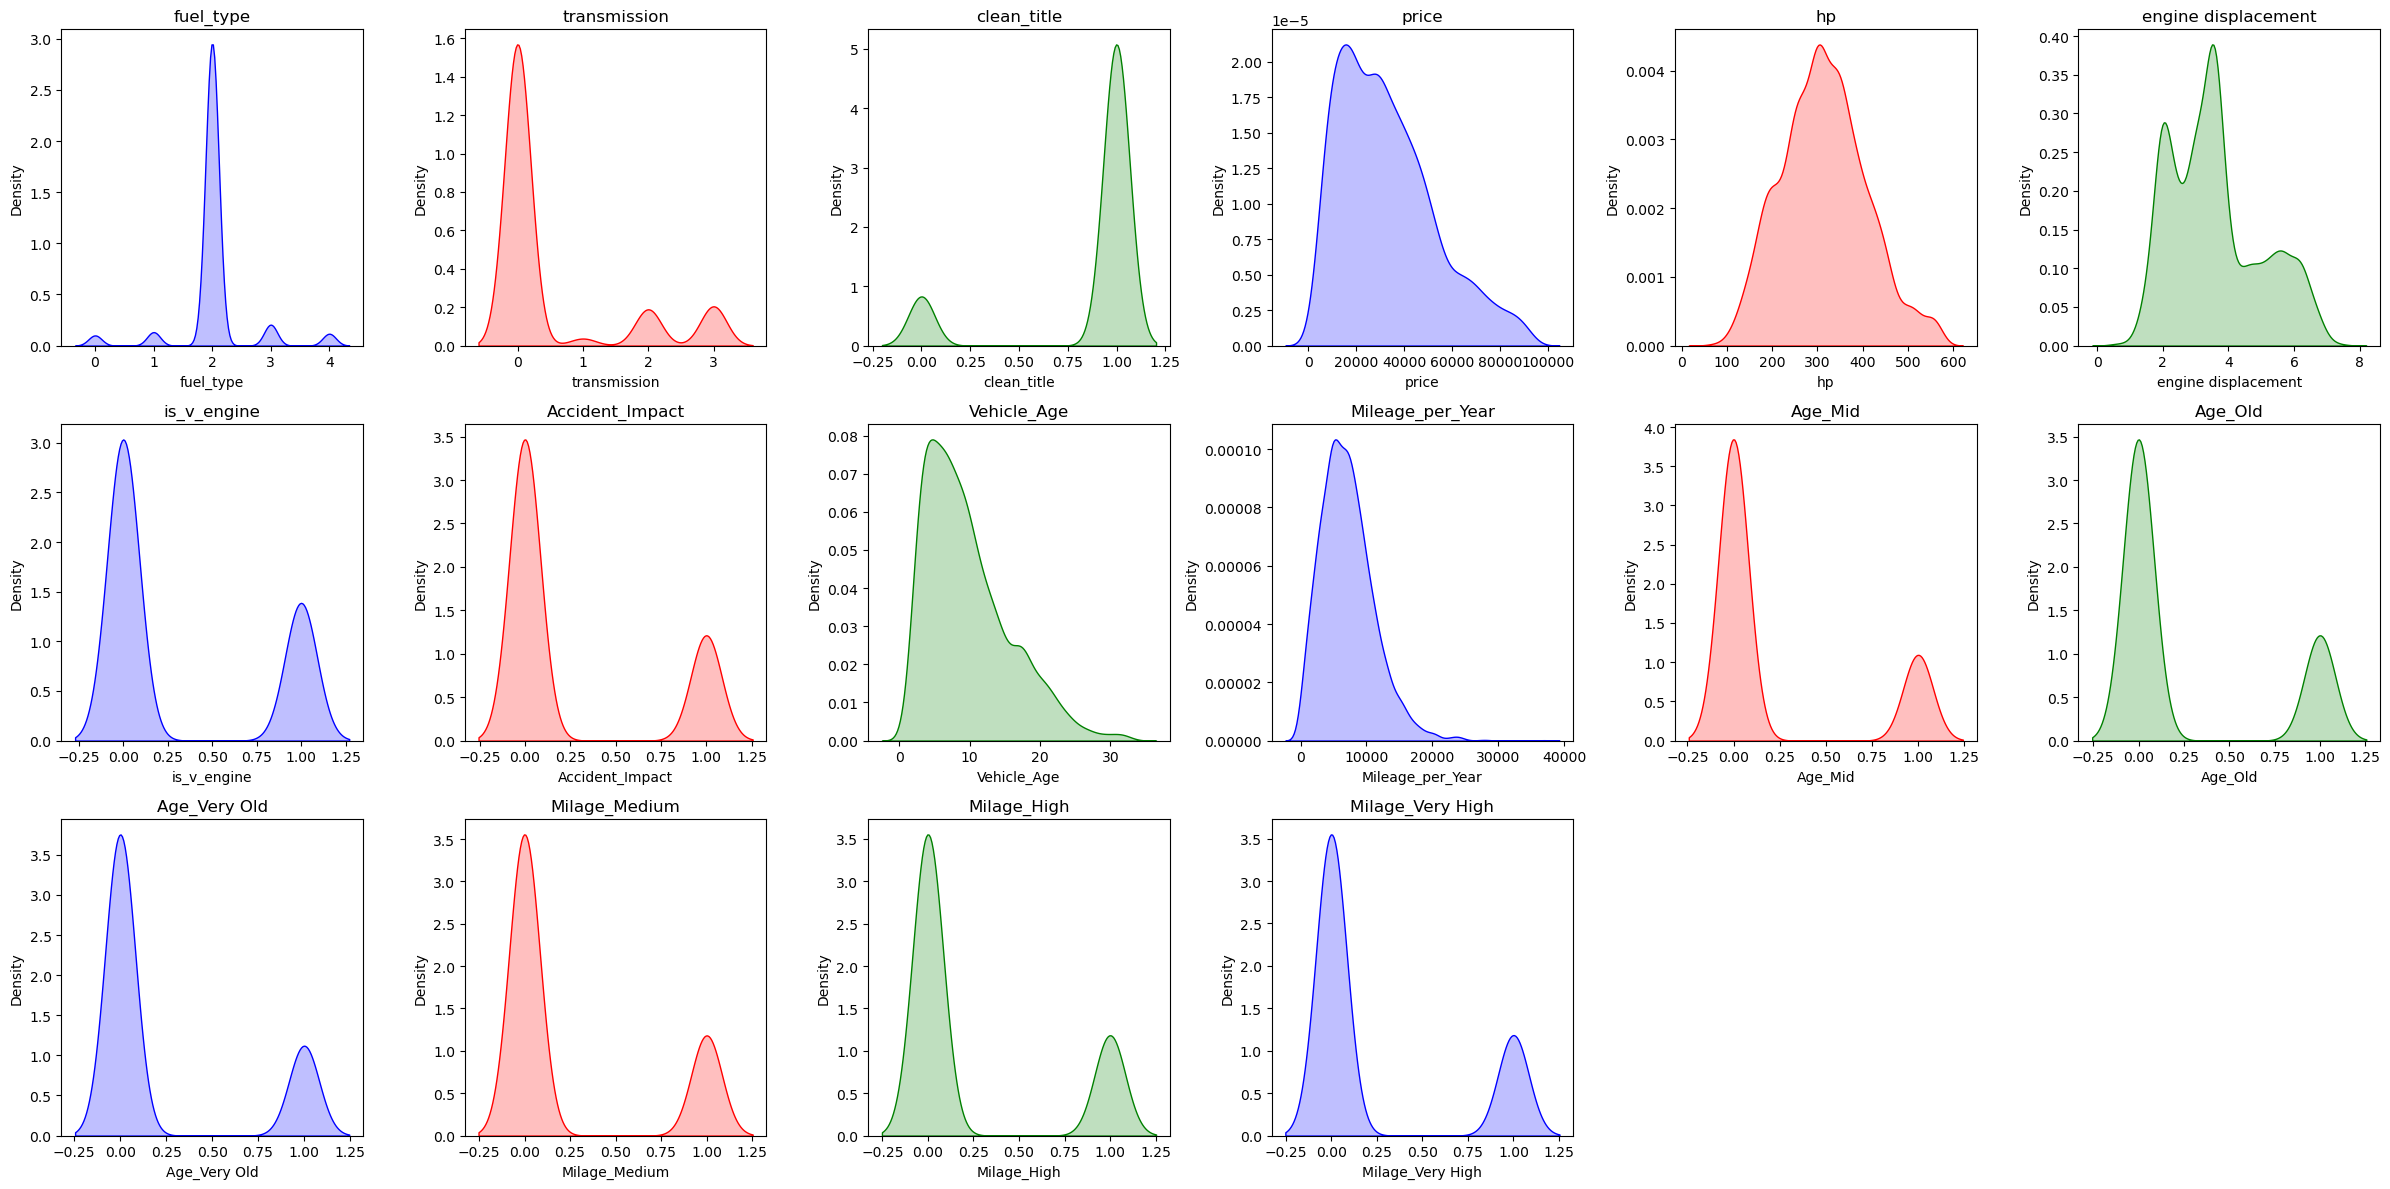

In [156]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

n_rows = 3
numeric_column_name = df.select_dtypes(include='number').columns
n_cols = int(np.ceil(len(numeric_column_name)/n_rows))
colors = ['blue', 'red', 'green']

plt.figure(figsize=(4*n_cols, 4*n_rows))
for idx, column in enumerate(numeric_column_name, 1):
    plt.subplot(n_rows, n_cols, idx)
    sns.kdeplot(
        data=df,
        x=column,
        fill=True,
        color=colors[(idx-1) % len(colors)]
    )
    plt.title(column)
plt.tight_layout()
plt.show()

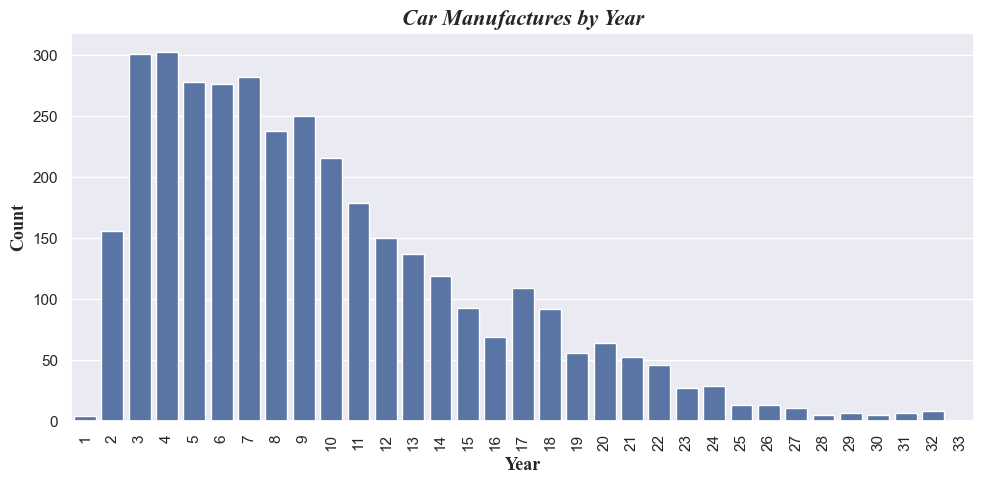

In [215]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='Vehicle_Age', width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Year', fontdict={'family': 'Times New Roman', 'size':13, 'weight': 'bold'})
plt.ylabel('Count', fontdict={'family': 'Times New Roman', 'size':13, 'weight': 'bold'})
plt.title('Car Manufactures by Year', fontdict={'family': 'Times New Roman', 'style': 'oblique', 'size':16, 'weight': 'bold'})
sns.set_style('darkgrid')
sns.set_theme('notebook')
plt.tight_layout()
plt.show()

In [244]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
!pip install xgboost

   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/56.8 MB ? eta -:--:--
    --------------------------------------- 1.0/56.8 MB 5.6 MB/s eta 0:00:10
   - -------------------------------------- 2.1/56.8 MB 4.4 MB/s eta 0:00:13
   -- ------------------------------------- 3.4/56.8 MB 4.9 MB/s eta 0:00:11
   --- ------------------------------------ 4.5/56.8 MB 4.9 MB/s eta 0:00:11
   --- ------------------------------------ 5.2/56.8 MB 4.7 MB/s eta 0:00:11
   ---- ----------------------------------- 6.0/56.8 MB 4.6 MB/s eta 0:00:12
   ---- ----------------------------------- 6.6/56.8 MB 4.5 MB/s eta 0:00:12
   ----- ---------------------------------- 7.3/56.8 MB 4.3 MB/s eta 0:00:12
   ----- ---------------------------------- 7.6/56.8 MB 4.2 MB/s eta 0:00:12
   ----- ---------------------------------- 8.4/56.8 MB 3.9 MB/s eta 0:00:13
   ------ --------------------------------- 9.2/56.8 MB 3.9 MB/s eta 0:00:13
   ------- --

# Model Building and Evaluation

## Import Libraries

In [247]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

## Split the data (Features, Target)

In [249]:
X = df.drop(['price'], axis = 1)
y = df['price']
y_log = np.log1p(y)

## Split the data (Train, Test)

In [251]:
X_train, X_test, y_train, y_test = train_test_split(X,y_log,test_size=0.2, random_state=42, shuffle=True)

## Target Encoding For Brand

In [253]:
brand_target_mean = X_train.join(y_train).groupby('brand')['price'].mean()

X_train['brand_encoded'] = X_train['brand'].map(brand_target_mean)
X_test['brand_encoded'] = X_test['brand'].map(brand_target_mean)

X_test['brand_encoded'] = X_test['brand_encoded'].fillna(y_train.mean())

X_train = X_train.drop(columns=['brand'])
X_test = X_test.drop(columns=['brand'])

## Features Scaling

In [255]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Linear Regression Model

### Model Training - Prediction

In [258]:
linearModel = LinearRegression()
linearModel.fit(X_train_scaled, y_train)

y_train_pred_log = linearModel.predict(X_train_scaled)
y_train_pred = np.expm1(y_train_pred_log)

y_test_pred_log = linearModel.predict(X_test_scaled)
y_test_pred = np.expm1(y_test_pred_log)

y_train_real = np.expm1(y_train)
y_test_real = np.expm1(y_test)

### Model Evaluation

In [260]:
lr_train_mae = mean_absolute_error(y_train_real, y_train_pred)
lr_test_mae = mean_absolute_error(y_test_real, y_test_pred)

print(f"MAE Training: {lr_train_mae:.2f}")
print(f"MAE Testing: {lr_test_mae:.2f}")

MAE Training: 7400.36
MAE Testing: 7539.31


In [261]:
lr_rmse_train = np.sqrt(mean_squared_error(y_train_real, y_train_pred))
lr_rmse_test = np.sqrt(mean_squared_error(y_test_real, y_test_pred))

print(f"RMSE Training: {lr_rmse_test}")
print(f"RMSE Testing: {lr_rmse_train}")

RMSE Training: 11183.129202548374
RMSE Testing: 10776.382269038817


In [262]:
lr_train_r2 = r2_score(y_train_real, y_train_pred)
lr_test_r2 = r2_score(y_test_real, y_test_pred)

print(f"R² Training: {lr_train_r2:.2f}")
print(f"R² Testing: {lr_test_r2:.2f}")

R² Training: 0.71
R² Testing: 0.68


## Random Forest Regressor

### Hyperparameter Tuning

In [265]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [8, 10, 12],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['sqrt']
}

scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'RMSE': make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False),
                        greater_is_better=False),
    'R2': make_scorer(r2_score)
}


### Model Training - Prediction

In [ ]:
rf_model = RandomForestRegressor(random_state=40)

kf = KFold(n_splits=7, shuffle=True, random_state=42)

rf_grid = GridSearchCV(rf_model, param_grid, scoring=scoring, refit='RMSE', cv=kf, n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)

print("✅ Best parameters from CV:", rf_grid.best_params_)

In [ ]:
best_rf_model = rf_grid.best_estimator_

y_train_pred_log = best_rf_model.predict(X_train_scaled)
y_train_pred = np.expm1(y_train_pred_log)

y_test_pred_log = best_rf_model.predict(X_test_scaled)
y_test_pred = np.expm1(y_test_pred_log)

y_test_real = np.expm1(y_test)
y_train_real = np.expm1(y_train)

### Cross Validation - Error Analysis

In [ ]:
rf_cv_results = pd.DataFrame(rf_grid.cv_results_)
cols = ['param_n_estimators','param_max_depth','param_min_samples_split', 'param_min_samples_leaf', 'param_max_features',
        'mean_test_R2','mean_test_MAE','mean_test_RMSE']

rf_cv_results[cols].sort_values(by='mean_test_RMSE',ascending=False).head(10)

In [ ]:
rf_errors = pd.DataFrame({
    'Actual': y_test_real,
    'Predicted': y_test_pred,
    'Absolute Error': np.abs(y_test_real - y_test_pred)
})

rf_worst_cases = rf_errors.sort_values(by='Absolute Error', ascending=False).head(10)
print("\nWorst 10 predictions:")
rf_worst_cases

### Model Evaluation

In [ ]:
rf_train_mae = mean_absolute_error(y_train_real, y_train_pred)
rf_test_mae = mean_absolute_error(y_test_real, y_test_pred)

print(f"MAE Training: {rf_train_mae:.2f}")
print(f"MAE Testing: {rf_test_mae:.2f}")

In [ ]:
rf_train_rmse = np.sqrt(mean_squared_error(y_train_real, y_train_pred))
rf_test_rmse = np.sqrt(mean_squared_error(y_test_real, y_test_pred))

print(f"RMSE Training: {rf_train_rmse:.2f}")
print(f"RMSE Testing: {rf_test_rmse:.2f}")

In [ ]:
rf_train_r2 = r2_score(y_train_real, y_train_pred)
rf_test_r2 = r2_score(y_test_real, y_test_pred)

print(f"R² Training: {rf_train_r2:.2f}")
print(f"R² Testing: {rf_test_r2:.2f}")

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(y_test_real, y_test_pred, alpha=0.5)
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_pred.min(), y_test_pred.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")

plt.tight_layout()
plt.show()

## Support Vector Regressor

### Hyperparameter Tuning

In [ ]:
svr_param_grid = {
    "C" : [0.1, 1, 10, 100],
    "epsilon" : [0.01, 0.1, 0.2, 0.5],
    "kernel": ["linear", "rbf"],
    "gamma" : ["scale", "auto"]
}

scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'RMSE': make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False),
                        greater_is_better=False),
    'R2': make_scorer(r2_score)
}

kf = KFold(n_splits=7, shuffle=True, random_state=42)

svr = SVR()

svr_grid_search = GridSearchCV(
    estimator=svr,
    param_grid=svr_param_grid,
    scoring=scoring,
    refit='RMSE',
    cv=kf,
    n_jobs=-1,
    verbose=0
)

### Model Training - Prediction

In [ ]:
svr_grid_search.fit(X_train_scaled, y_train)

best_svr_model = svr_grid_search.best_estimator_
print("\nBest SVR params:", svr_grid_search.best_params_)

In [ ]:
y_train_pred_log = best_svr_model.predict(X_train_scaled)
y_train_pred = np.expm1(y_train_pred_log)

y_test_pred_log = best_svr_model.predict(X_test_scaled)
y_test_pred = np.expm1(y_test_pred_log)

y_train_real = np.expm1(y_train)
y_test_real = np.expm1(y_test)

### Cross Validation - Error Analysis

In [ ]:
svr_cv_results = pd.DataFrame(svr_grid_search.cv_results_)
cols = ['param_C','param_epsilon','param_kernel', 'param_gamma',
        'mean_test_R2','mean_test_MAE','mean_test_RMSE']

svr_cv_results[cols].sort_values(by='mean_test_RMSE',ascending=False).head(10)

In [ ]:
svr_errors = pd.DataFrame({
    'Actual': y_test_real,
    'Predicted': y_test_pred,
    'Absolute Error': np.abs(y_test_real - y_test_pred)
})

svr_worst_cases = svr_errors.sort_values(by='Absolute Error', ascending=False).head(10)
print("\nWorst 10 predictions:")
svr_worst_cases

### Model Evaluation

In [ ]:
svr_train_mae = mean_absolute_error(y_train_real, y_train_pred)
svr_test_mae = mean_absolute_error(y_test_real, y_test_pred)

print(f"MAE Training: {svr_train_mae:.2f}")
print(f"MAE Testing: {svr_test_mae:.2f}")

In [ ]:
svr_train_rmse = np.sqrt(mean_squared_error(y_train_real, y_train_pred))
svr_test_rmse = np.sqrt(mean_squared_error(y_test_real, y_test_pred))

print(f"RMSE Training: {svr_train_rmse:.2f}")
print(f"RMSE Testing: {svr_test_rmse:.2f}")

In [ ]:
svr_train_r2 = r2_score(y_train_real, y_train_pred)
svr_test_r2 = r2_score(y_test_real, y_test_pred)

print(f"R² Training: {svr_train_r2:.2f}")
print(f"R² Testing: {svr_test_r2:.2f}")

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(y_test_real, y_test_pred, alpha=0.5)
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_pred.min(), y_test_pred.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")

plt.tight_layout()
plt.show()

## XGBoost Regressor

### Hyperparameter Tuning

In [ ]:
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.03],
    'max_depth': [5, 7],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.6, 0.8],
    'reg_lambda': [1, 10],
    'reg_alpha': [0, 1]
}

scoring = {
    'R2': 'r2',
    'MAE': 'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error'
}

kf = KFold(n_splits=7, shuffle=True, random_state=42)

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=40, early_stopping_rounds=30)

grid_xgb = GridSearchCV(
    xgb_model,
    param_grid_xgb,
    scoring=scoring,
    refit='RMSE',
    cv=kf,
    n_jobs=-1,
    verbose=1
)

### Model Training - Prediction

In [ ]:
grid_xgb.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)

best_xgb_model = grid_xgb.best_estimator_
print("Best parameters:", grid_xgb.best_params_)

In [ ]:
y_train_pred_log = best_xgb_model.predict(X_train_scaled)
y_train_pred = np.expm1(y_train_pred_log)

y_test_pred_log = best_xgb_model.predict(X_test_scaled)
y_test_pred = np.expm1(y_test_pred_log)

y_test_real = np.expm1(y_test)
y_train_real = np.expm1(y_train)

### Cross Validation - Error Analysis

In [ ]:
xgb_cv_results = pd.DataFrame(grid_xgb.cv_results_)
cols = ['param_n_estimators','param_learning_rate','param_max_depth', 'param_subsample', 'param_colsample_bytree', 'param_reg_lambda', 'param_reg_alpha',
        'mean_test_R2','mean_test_MAE','mean_test_RMSE']

xgb_cv_results[cols].sort_values(by='mean_test_RMSE',ascending=False).head(10)

In [ ]:
xgb_errors = pd.DataFrame({
    'Actual': y_test_real,
    'Predicted': y_test_pred,
    'Absolute Error': np.abs(y_test_real - y_test_pred)
})

xgb_worst_cases = xgb_errors.sort_values(by='Absolute Error', ascending=False).head(10)
print("\nWorst 10 predictions:")
xgb_worst_cases

### Model Evaluation

In [ ]:
xgb_train_mae = mean_absolute_error(y_train_real, y_train_pred)
xgb_test_mae = mean_absolute_error(y_test_real, y_test_pred)

print(f"MAE Training: {xgb_train_mae:.2f}")
print(f"MAE Testing: {xgb_test_mae:.2f}")

In [ ]:
xgb_train_rmse = np.sqrt(mean_squared_error(y_train_real, y_train_pred))
xgb_test_rmse = np.sqrt(mean_squared_error(y_test_real, y_test_pred))

print(f"RMSE Training: {xgb_train_rmse:.2f}")
print(f"RMSE Testing: {xgb_test_rmse:.2f}")

In [ ]:
xgb_train_r2 = r2_score(y_train_real, y_train_pred)
xgb_test_r2 = r2_score(y_test_real, y_test_pred)

print(f"R² Training: {xgb_train_r2:.2f}")
print(f"R² Testing: {xgb_test_r2:.2f}")

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(y_test_real, y_test_pred, alpha=0.5)
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_pred.min(), y_test_pred.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")

plt.tight_layout()
plt.show()

In [ ]:
importances = pd.Series(best_xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importances:\n", importances)
plt.figure(figsize=(13,6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("XGB Feature Importances")
plt.show()

# Summary

### 📌 Project Summary

This project focuses on predicting used car prices using machine learning models trained on historical data. We explored multiple regression models, applied feature engineering, and evaluated model performance using MAE, RMSE, R² to identify the best performer.

---

### ✅ Models Trained & Compared

| Model                    | Test RMSE | Test R²  | perdict          |
|--------------------------|-----------|----------|------------------|
| Linear Regression        | ~10770.80 | 0.66     | Overfitting ❌   |
| Random Forest            | ~9446.60  | 0.77     | Good ✅          |
| Support Vector Regressor | ~9756.67  | 0.76     | Good ✅          |
| XGBoost                  | ~8176.96  | 0.83     | Best ✅✅        |

**XGBoost** showed the best performance, achieving the lowest RMSE, the highest R² which reflects superior accuracy and generalization.